<a href="https://colab.research.google.com/github/yashwardhan-gautam/Grid2.0/blob/master/VoiceFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Basic necessary definitions

#### Hyper Parameters

In [ ]:
class HyperParams:
  n_fft= 1200
  num_freq= 601 # n_fft//2 + 1
  sample_rate= 16000
  hop_length= 160
  win_length= 400
  min_level_db= -100.0
  ref_level_db= 20.0
  preemphasis= 0.97
  power= 0.30
  embedder_window= 80
  data_audio_len= 3.0
  embedder_num_mels= 40
  embedder_lstm_hidden = 768
  embedder_emb_dim = 256
  embedder_lstm_layers = 3
  embedder_window = 80
  embedder_stride = 40
  model_lstm_dim = 400
  model_fc1_dim = 600
  model_fc2_dim = 601 # num_freq

#### Audio related helper functions

In [ ]:
import librosa
import numpy as np  

In [ ]:
class Audio:
  def __init__(self,hyper_params):
    self.hyper_params = hyper_params
    self.mel_basis_matrix = librosa.filters.mel(sr=hyper_params.sample_rate,
                                             n_fft=hyper_params.n_fft,
                                             n_mels=hyper_params.embedder_num_mels);

  def get_mel_spec(self,wave):
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                              hop_length=self.hyper_params.hop_length,
                              win_length=self.hyper_params.win_length,
                              window='hann')
    power_spec = np.abs(spec) ** 2
    mel_spec = np.log10(np.dot(self.mel_basis_matrix,power_spec)+1e-6)
    return mel_spec  
  def wave2spec(self,wave): 
    spec = librosa.core.stft(y=wave, n_fft=self.hyper_params.n_fft,
                            hop_length=self.hyper_params.hop_length,
                            win_length=self.hyper_params.win_length)
    phase = np.angle(spec)
    spec_db = self.amp2db(np.abs(spec))
    spec_db_norm = self.normalize(spec_db)
    spec_db_norm = spec_db_norm.T   # Taking transpose here
    phase = phase.T # Taking transpose here
    return spec_db_norm, phase
  def spec2wave(self,spec_db_norm,phase):
    spec_db_norm, phase = spec_db_norm.T, phase.T
    spec_db = self.denormalize(spec_db_norm)
    spec_amp = self.db2amp(spec_db)
    spec = spec_amp * np.exp(1j*phase)
    wave = librosa.core.istft(spec,
                             hop_length=self.hyper_params.hop_length,
                             win_length=self.hyper_params.win_length)
    return wave
  def amp2db(self,mat):
    return 20.0 * np.log10(np.maximum(1e-5,mat)) - self.hyper_params.ref_level_db
  def db2amp(self,mat):
    return np.power(10.0, (mat+self.hyper_params.ref_level_db)*0.05)
  def normalize(self,mat):
    return np.clip((mat-self.hyper_params.min_level_db)/-self.hyper_params.min_level_db, 0.0 , 1.0)
  def denormalize(self, mat):
    return np.clip(mat,0.0,1.0)*(-self.hyper_params.min_level_db)+self.hyper_params.min_level_db

In [ ]:
hyper_params = HyperParams()
audio = Audio(hyper_params)

#### Define paths and create folders

In [ ]:
import os

In [ ]:
# dataset_path = os.path.join('drive','MyDrive','CS753 ASR Project','LibriSpeech Dataset');
!mkdir './LibriSpeech Dataset'
dataset_path = os.path.join('./LibriSpeech Dataset');
path = {}
path['dev'] = os.path.join(dataset_path,'LibriSpeech Dev Dataset')
path['test'] = os.path.join(dataset_path,'LibriSpeech Test Dataset')
path['train'] = os.path.join(dataset_path ,'LibriSpeech Train Dataset')

In [ ]:
# create directories to store dataset
for dataset in ('dev','test','train'):
  os.makedirs(os.path.join(path[dataset],'input_spec'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'output_spec'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'input_phase'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'output_phase'),exist_ok=True)
  os.makedirs(os.path.join(path[dataset],'dvec'),exist_ok=True)
print('Directories created')

Directories created


In [ ]:
# create 8 separate directories for training dataset to avoid issues with gdrive
def create_folders(i):
  os.makedirs(os.path.join(path['train'],'input_spec_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'output_spec_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'input_phase_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'output_phase_'+i),exist_ok=True)
  os.makedirs(os.path.join(path['train'],'dvec_'+i),exist_ok=True)

for i in range(8):
  create_folders(str(i))
print('Directories created')

Directories created


### Unzip LibriSpeech dataset ( Execute just once )
ALREADY DONE IN DATA PREPARATION. DO NOT REPEAT.

ALSO, USE LINUX COMMANDS TO FIRST EXTRACT DATASETS IN VM, AND THEN MOVE TO DRIVE INSTEAD OF USING SHUTIL TO DIRECTLY EXTRACT IN DRIVE.

In [ ]:
# import shutil

In [ ]:
# shutil.unpack_archive(dataset_path+'/train-clean-100.tar.gz',dataset_path)
# Rename the extracted folder LibriSpeech to LibriSpeech Train Dataset

In [ ]:
# shutil.unpack_archive(dataset_path+'/dev-clean.tar.gz',dataset_path)
# Rename the extracted folder LibriSpeech to LibriSpeech Dev Dataset

In [ ]:
# shutil.unpack_archive(dataset_path+'/test-clean.tar.gz',dataset_path)
# Rename the extracted folder LibriSpeech to LibriSpeech Test Dataset

In [ ]:
# !rm -r "drive/MyDrive/LibriSpeech Dataset/"

In [ ]:
# !mkdir "drive/MyDrive/LibriSpeech Dataset/"
# !mkdir "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset"
# !mkdir "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset"
# !mkdir "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# %ls "drive/MyDrive/LibriSpeech Dataset/"

# %cd "LibriSpeech Dataset/"

# !wget https://www.openslr.org/resources/12/test-clean.tar.gz
# !time cp "test-clean.tar.gz" "../drive/MyDrive/LibriSpeech Dataset/"
# !tar -xf "test-clean.tar.gz"
# !mv LibriSpeech "LibriSpeech Test Dataset"

# !wget https://www.openslr.org/resources/12/dev-clean.tar.gz
# !time cp "dev-clean.tar.gz" "../drive/MyDrive/LibriSpeech Dataset/"
# !tar -xf "dev-clean.tar.gz"
# !mv LibriSpeech "LibriSpeech Dev Dataset"

# !wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
# !time cp "train-clean-100.tar.gz" "../drive/MyDrive/LibriSpeech Dataset/" # approx 4 mins
# !tar -xf "train-clean-100.tar.gz"
# !mv LibriSpeech "LibriSpeech Train Dataset"

# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1YFmhmUok-W76JkrfA0fzQt3c-ZsfiwfL' -O embedder.pt
# !cp embedder.pt "../drive/MyDrive/LibriSpeech Dataset/"

# %cd ..

In [ ]:
# takes approx 6 mins
%cd "LibriSpeech Dataset/"
!time cp "../drive/MyDrive/LibriSpeech Dataset/train-clean-100.tar.gz" .
!time tar -xf train-clean-100.tar.gz
!mv LibriSpeech "LibriSpeech Train Dataset"
!rm train-clean-100.tar.gz

!time cp "../drive/MyDrive/LibriSpeech Dataset/test-clean.tar.gz" .
!tar -xf "test-clean.tar.gz"
!mv LibriSpeech "LibriSpeech Test Dataset"
!rm test-clean.tar.gz

!time cp "../drive/MyDrive/LibriSpeech Dataset/dev-clean.tar.gz" .
!tar -xf "dev-clean.tar.gz"
!mv LibriSpeech "LibriSpeech Dev Dataset"
!rm dev-clean.tar.gz

!time cp "../drive/MyDrive/LibriSpeech Dataset/embedder.pt" .
%cd ..

/content/LibriSpeech Dataset

real	2m25.992s
user	0m0.027s
sys	0m7.141s

real	1m17.077s
user	0m37.053s
sys	0m14.782s

real	0m6.888s
user	0m0.001s
sys	0m0.419s

real	0m9.050s
user	0m0.001s
sys	0m0.452s

real	0m1.684s
user	0m0.000s
sys	0m0.066s
/content


In [ ]:
## takes approx 35 mins
## copy train dataset
%cd "LibriSpeech Dataset/LibriSpeech Train Dataset/"

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/dvec9.tar" .
!time tar -xf dvec9.tar
!mv "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/"
!rm dvec9.tar
print("dvec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase9.tar" .
!time tar -xf input_phase9.tar
!mv "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/"
!rm input_phase9.tar
print("input_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase9.tar" .
!time tar -xf output_phase9.tar
!mv "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/"
!rm output_phase9.tar
print("output_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec9.tar" .
!time tar -xf input_spec9.tar
!mv "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/"
!rm input_spec9.tar
print("input_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec9.tar" .
!time tar -xf output_spec9.tar
!mv "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/"
!rm output_spec9.tar
print("output_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches9.data" train_speeches.data
!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame9.csv" data_frame.csv
print("ALL done")

%cd ../..

%ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" | wc -l
!wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data"
!wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv"

/content/LibriSpeech Dataset/LibriSpeech Train Dataset

real	0m1.220s
user	0m0.003s
sys	0m0.020s

real	0m0.236s
user	0m0.017s
sys	0m0.218s
dvec done

real	2m12.376s
user	0m0.026s
sys	0m6.065s

real	1m9.891s
user	0m0.143s
sys	0m6.184s
input_phase done

real	2m19.856s
user	0m0.019s
sys	0m6.241s

real	1m7.028s
user	0m0.115s
sys	0m6.178s
output_phase done

real	2m15.188s
user	0m0.015s
sys	0m6.199s

real	1m9.244s
user	0m0.124s
sys	0m6.219s
input_spec done

real	2m14.762s
user	0m0.018s
sys	0m6.354s

real	1m9.228s
user	0m0.141s
sys	0m6.283s
output_spec done

real	0m4.773s
user	0m0.002s
sys	0m0.005s

real	0m0.745s
user	0m0.000s
sys	0m0.010s
ALL done
/content
7594
7594
7594
7594
7594
369 LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data
7594 LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv


In [ ]:
## copy test dataset
%cd "LibriSpeech Dataset/LibriSpeech Test Dataset/"

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/dvec.tar" .
!time tar -xf dvec.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/dvec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm dvec.tar
print("dvec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase.tar" .
!time tar -xf input_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm input_phase.tar
print("input_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase.tar" .
!time tar -xf output_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm output_phase.tar
print("output_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec.tar" .
!time tar -xf input_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm input_spec.tar
print("input_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec.tar" .
!time tar -xf output_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
!rm output_spec.tar
print("output_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data" test_speeches.data
!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv" data_frame.csv
print("ALL done")

%cd ../..

%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/dvec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec/" | wc -l
!wc -l "LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data"
!wc -l "LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv"

/content/LibriSpeech Dataset/LibriSpeech Test Dataset

real	0m0.704s
user	0m0.000s
sys	0m0.006s

real	0m0.033s
user	0m0.004s
sys	0m0.029s
dvec done

real	0m12.415s
user	0m0.005s
sys	0m0.847s

real	0m2.972s
user	0m0.019s
sys	0m0.766s
input_phase done

real	0m19.810s
user	0m0.005s
sys	0m0.743s

real	0m8.388s
user	0m0.023s
sys	0m0.705s
output_phase done

real	0m14.189s
user	0m0.003s
sys	0m0.823s

real	0m7.964s
user	0m0.018s
sys	0m0.759s
input_spec done

real	0m19.630s
user	0m0.007s
sys	0m0.760s

real	0m8.505s
user	0m0.023s
sys	0m0.752s
output_spec done

real	0m0.401s
user	0m0.000s
sys	0m0.004s

real	0m0.480s
user	0m0.000s
sys	0m0.005s
ALL done
/content
950
950
950
950
950
112 LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data
950 LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv


In [ ]:
## copy dev dataset
%cd "LibriSpeech Dataset/LibriSpeech Dev Dataset/"

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec.tar" .
!time tar -xf dvec.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm dvec.tar
print("dvec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase.tar" .
!time tar -xf input_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm input_phase.tar
print("input_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase.tar" .
!time tar -xf output_phase.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm output_phase.tar
print("output_phase done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec.tar" .
!time tar -xf input_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm input_spec.tar
print("input_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec.tar" .
!time tar -xf output_spec.tar
!mv "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec/" .
!rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
!rm output_spec.tar
print("output_spec done")

!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data" dev_speeches.data
!time cp "../../drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv" data_frame.csv
print("ALL done")

%cd ../..

%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec/" | wc -l
%ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec/" | wc -l
!wc -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data"
!wc -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv"

/content/LibriSpeech Dataset/LibriSpeech Dev Dataset

real	0m0.805s
user	0m0.002s
sys	0m0.005s

real	0m0.032s
user	0m0.004s
sys	0m0.028s
dvec done

real	0m14.519s
user	0m0.003s
sys	0m0.806s

real	0m3.203s
user	0m0.024s
sys	0m0.730s
input_phase done

real	0m18.296s
user	0m0.004s
sys	0m0.842s

real	0m7.063s
user	0m0.012s
sys	0m0.732s
output_phase done

real	0m18.365s
user	0m0.005s
sys	0m0.861s

real	0m6.180s
user	0m0.022s
sys	0m0.724s
input_spec done

real	0m16.399s
user	0m0.006s
sys	0m0.841s

real	0m7.495s
user	0m0.015s
sys	0m0.741s
output_spec done

real	0m5.002s
user	0m0.001s
sys	0m0.004s

real	0m0.526s
user	0m0.001s
sys	0m0.003s
ALL done
/content
921
921
921
921
921
195 LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data
921 LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv


### Create and store speech collection

In [ ]:
import glob
import pickle

In [ ]:
# #### Run this cell only the first time ####
# dev_base_path = os.path.join(path['dev'],'LibriSpeech','dev-clean')
# test_base_path = os.path.join(path['test'],'LibriSpeech','test-clean')
# train_base_path = os.path.join(path['train'],'LibriSpeech','train-clean-100')

In [ ]:
# #### Run this cell only the first time ####
# dev_spks = os.listdir(dev_base_path)
# # list of all speaker folders
# dev_speeches = [glob.glob(os.path.join(dev_base_path,spk,'*','*.flac'),recursive=True) for spk in dev_spks]
# dev_speeches = [speeches for speeches in dev_speeches if len(speeches)>=2]
# # list of lists containing speeches of a speaker
# test_spks = os.listdir(test_base_path)
# # list of all speaker folders
# test_speeches = [glob.glob(os.path.join(test_base_path,spk,'*','*.flac'),recursive=True) for spk in test_spks]
# test_speeches = [speeches for speeches in test_speeches if len(speeches)>=2]
# # list of lists containing speeches of a speaker
# train_spks = os.listdir(train_base_path)
# # list of all speaker folders
# train_speeches = [glob.glob(os.path.join(train_base_path,spk,'*','*.flac'),recursive=True) for spk in train_spks]
# train_speeches = [speeches for speeches in train_speeches if len(speeches)>=2]
# # list of lists containing speeches of a speaker

In [ ]:
##### Run this cell only the first time #####
# with open(os.path.join(path['dev'],'dev_speeches.data'),'wb') as f:
#   pickle.dump(dev_speeches,f)
# with open(os.path.join(path['test'],'test_speeches.data'),'wb') as f:
#   pickle.dump(test_speeches,f)
# with open(os.path.join(path['train'],'train_speeches.data'),'wb') as f:
#   pickle.dump(train_speeches,f)

In [ ]:
with open(os.path.join(path['dev'],'dev_speeches.data'),'rb') as f:
  dev_speeches = pickle.load(f)
with open(os.path.join(path['test'],'test_speeches.data'),'rb') as f:
  test_speeches = pickle.load(f)
with open(os.path.join(path['train'],'train_speeches.data'),'rb') as f:
  train_speeches = pickle.load(f)

### Use pre trained model to obtain Embedding

In [ ]:
import torch
import torch.nn as nn

class LinearNorm(nn.Module):
    def __init__(self, hp):
        super(LinearNorm, self).__init__()
        self.linear_layer = nn.Linear(hp.embedder_lstm_hidden, hp.embedder_emb_dim)

    def forward(self, x):
        return self.linear_layer(x)


class SpeechEmbedder(nn.Module):
    def __init__(self, hp):
        super(SpeechEmbedder, self).__init__()
        self.lstm = nn.LSTM(hp.embedder_num_mels,
                            hp.embedder_lstm_hidden,
                            num_layers=hp.embedder_lstm_layers,
                            batch_first=True)
        self.proj = LinearNorm(hp)
        self.hp = hp

    def forward(self, mel):
        # (num_mels, T)
        mels = mel.unfold(1, self.hp.embedder_window, self.hp.embedder_stride) # (num_mels, T', window)
        mels = mels.permute(1, 2, 0) # (T', window, num_mels)
        x, _ = self.lstm(mels) # (T', window, lstm_hidden)
        x = x[:, -1, :] # (T', lstm_hidden), use last frame only
        x = self.proj(x) # (T', emb_dim)
        x = x / torch.norm(x, p=2, dim=1, keepdim=True) # (T', emb_dim)
        x = x.sum(0) / x.size(0) # (emb_dim), average pooling over time frames
        return x

In [ ]:
# Embedder downloaded from https://drive.google.com/file/d/1YFmhmUok-W76JkrfA0fzQt3c-ZsfiwfL/view (https://github.com/mindslab-ai/voicefilter)
embedder_path = os.path.join(dataset_path,"embedder.pt")
embedder_pt = torch.load(embedder_path,map_location=torch.device('cpu'))
embedder = SpeechEmbedder(hyper_params)
embedder.load_state_dict(embedder_pt)
embedder.eval()

SpeechEmbedder(
  (lstm): LSTM(40, 768, num_layers=3, batch_first=True)
  (proj): LinearNorm(
    (linear_layer): Linear(in_features=768, out_features=256, bias=True)
  )
)

### Prepare dataset

In [ ]:
import random
import pandas as pd

In [ ]:
# returns dvec for the input wave using pre trained embedder model
def get_dvector(wave):
  mel_spec = audio.get_mel_spec(wave)
  dvec = embedder(torch.from_numpy(mel_spec).float())
  dvec = dvec.detach().numpy()
  return dvec

In [ ]:
# pre process waves and store spectrogram, phase and dvector in their respective folders
def create_example(target_dir, hyper_params, idx, ref_speech, pri_speech, sec_speech):
  sample_rate = hyper_params.sample_rate
  ref_wave, _ = librosa.load(ref_speech,sr=sample_rate) #load the audio file
  pri_wave, _ = librosa.load(pri_speech, sr = sample_rate)
  sec_wave,_ = librosa.load(sec_speech, sr = sample_rate)
  assert len(ref_wave.shape)==len(pri_wave.shape)==len(sec_wave.shape)==1,\
  'wave files must be mono and not stereo'
  ref_wave,_ = librosa.effects.trim(ref_wave, top_db = 20) # clip silent portion on both ends
  pri_wave,_ = librosa.effects.trim(pri_wave, top_db = 20)
  sec_wave,_ = librosa.effects.trim(sec_wave, top_db = 20)
  
  if ref_wave.shape[0] < 1.1 * hyper_params.embedder_window * hyper_params.hop_length :
    return
  length_wave = int(sample_rate * hyper_params.data_audio_len)
  if pri_wave.shape[0]<length_wave or sec_wave.shape[0]<length_wave:
    return
  pri_wave, sec_wave = pri_wave[:length_wave], sec_wave[:length_wave] # clip wave to fixed length
  mix_wave = pri_wave + sec_wave
  norm = np.max(np.abs(mix_wave)) * 1.1
  pri_wave, mix_wave = pri_wave/norm , mix_wave/norm  # normalize wave by 1.1*max(absolute amplitude)
  pri_spec, pri_phase = audio.wave2spec(pri_wave)  # convert wave to spec
  mix_spec, mix_phase = audio.wave2spec(mix_wave)
  dvec = get_dvector(ref_wave)

  # paths for storing data
  pri_spec_path = os.path.join(target_dir,'output_spec','%06d.npy'%idx)
  pri_phase_path = os.path.join(target_dir,'output_phase','%06d.npy'%idx)
  mix_spec_path = os.path.join(target_dir, 'input_spec','%06d.npy'%idx)
  mix_phase_path = os.path.join(target_dir,'input_phase','%06d.npy'%idx)
  dvec_path = os.path.join(target_dir,'dvec','%06d.npy'%idx)
  # store data on paths above
  np.save(pri_spec_path,pri_spec)
  np.save(mix_spec_path,mix_spec)
  np.save(mix_phase_path, mix_phase)
  np.save(pri_phase_path, pri_phase)
  np.save(dvec_path,dvec)

  #print(idx)
  return [idx, ref_speech, pri_speech, sec_speech,  mix_spec_path, pri_spec_path, mix_phase_path, pri_phase_path, dvec_path]

In [ ]:
columns=['key','ref_speech','pri_speech','sec_speech','input_spec_path','output_spec_path','input_phase_path','output_phase_path','dvec_path']

In [ ]:
#### to be run just once ####
# sample_data_frame = pd.DataFrame(data = [], columns=columns)
# for dataset in ('train','dev','test'):
#   sample_data_frame.to_csv(os.path.join(path[dataset],'data_frame.csv'),index=False);

In [ ]:
def create_dataset(i):
  batch = []
  array = range(i+1,n+1)
  if parity == 1:
    array = range(1,i)
  for j in array:
    first = min(i,j)
    sec = max(i,j)
    if (sec-first)%2 == parity:
      first, sec = sec, first
    n1 = len(speeches[first-1]) # -1 accounts for zero based indexing
    n2 = len(speeches[sec-1]) # -1 accounts for zero based indexing
    sum = first+sec-1 # -1 accounts for zero based indexing
    diff = first-sec-1 # -1 accounts for zero based indexing
    diff_mod = (abs(diff))%n1
    if diff < 0 and diff_mod > 0:
      diff_mod = n1 - diff_mod
    ref_speech = speeches[first-1][diff_mod]
    pri_speech = speeches[first-1][sum%n1]
    sec_speech = speeches[sec-1][first%n2]
    row = create_example( path[dataset], hyper_params , n*(i-1) + j, ref_speech, pri_speech, sec_speech)
    if row is not None:
      batch.append(row)
  print(i)
  return batch

In [ ]:
def save_batch(dataset,data):
  df_path = os.path.join(path[dataset],'data_frame.csv')
  df = pd.read_csv(df_path)
  df_batch = pd.DataFrame(data = data, columns = columns)
  df = df.append(df_batch)
  df.to_csv(df_path,index=False)

In [ ]:
import os
import time
from multiprocessing import Pool
cpu_num = len(os.sched_getaffinity(0))

In [ ]:
print("Number of cpu available : ",cpu_num)

Number of cpu available :  4


#### Dev set

In [ ]:
# dataset = 'dev' # important global variable
# speeches = dev_speeches # important global variable
# n = len(dev_speeches) # important global variable
# print("number of speakers(dev set) : ",n)
# for i in range(n):
#   random.shuffle(dev_speeches[i])  # shuffle the speeches of all speakers
# arr = list(range(1,n+1))  # create a list for all speakers

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('dev',data)

In [ ]:
# data = []
# parity = 1 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('dev',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv"

# !time tar -cf dvec.tar "LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec/"
# !cp dvec.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm dvec.tar

# !time tar -cf input_phase.tar "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase/"
# !cp input_phase.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm input_phase.tar

# !time tar -cf output_phase.tar "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase/"
# !cp output_phase.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm output_phase.tar

# !time tar -cf input_spec.tar "LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec/"
# !cp input_spec.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm input_spec.tar

# !time tar -cf output_spec.tar "LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec/"
# !cp output_spec.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm output_spec.tar

# !cp "LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !cp "LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/"

# %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/dvec.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/input_phase.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/output_phase.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/input_spec.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/output_spec.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/dev_speeches.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Dev Dataset/data_frame.csv"

#### Test set

In [ ]:
# dataset = 'test' # important global variable
# speeches = test_speeches # important global variable
# n = len(test_speeches) # important global variable
# print("number of speakers(test set) : ",n)
# for i in range(n):
#   random.shuffle(test_speeches[i])  # shuffle the speeches of all speakers
# arr = list(range(1,n+1))  # create a list for all speakers

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('test',data)

In [ ]:
# data = []
# parity = 1 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('test',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv"

# !time tar -cf dvec.tar "LibriSpeech Dataset/LibriSpeech Test Dataset/dvec/"
# !cp dvec.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm dvec.tar

# !time tar -cf input_phase.tar "LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase/"
# !cp input_phase.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm input_phase.tar

# !time tar -cf output_phase.tar "LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase/"
# !cp output_phase.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm output_phase.tar

# !time tar -cf input_spec.tar "LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec/"
# !cp input_spec.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm input_spec.tar

# !time tar -cf output_spec.tar "LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec/"
# !cp output_spec.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm output_spec.tar

# !cp "LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !cp "LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/"

# %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/dvec.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/input_phase.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/output_phase.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/input_spec.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/output_spec.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/test_speeches.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Test Dataset/data_frame.csv"

#### Train set

In [ ]:
# dataset = 'train' # important global variable
# speeches = train_speeches # important global variable
# # n = len(train_speeches) # important global variable
# n = 200  ## to speedup train dataset
# print("number of speakers(train set) : ",n)
# for i in range(n):
#   random.shuffle(train_speeches[i])  # shuffle the speeches of all speakers
# arr = list(range(1,n+1))  # create a list for all speakers

##### 0-100

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[0:25] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv"

# !time tar -cf dvec1.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/"
# !time cp dvec1.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm dvec1.tar

# !time tar -cf input_phase1.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/"
# !time cp input_phase1.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_phase1.tar

# !time tar -cf output_phase1.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/"
# !time cp output_phase1.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_phase1.tar

# !time tar -cf input_spec1.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/"
# !time cp input_spec1.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_spec1.tar

# !time tar -cf output_spec1.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/"
# !time cp output_spec1.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_spec1.tar

# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches1.data"
# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame1.csv"

# %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/dvec1.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase1.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase1.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec1.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec1.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches1.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame1.csv"

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[25:50] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv"

# !time tar -cf dvec2.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/"
# !time cp dvec2.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm dvec2.tar

# !time tar -cf input_phase2.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/"
# !time cp input_phase2.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_phase2.tar

# !time tar -cf output_phase2.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/"
# !time cp output_phase2.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_phase2.tar

# !time tar -cf input_spec2.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/"
# !time cp input_spec2.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_spec2.tar

# !time tar -cf output_spec2.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/"
# !time cp output_spec2.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_spec2.tar

# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches2.data"
# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame2.csv"

# %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/dvec2.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase2.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase2.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec2.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec2.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches2.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame2.csv"

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[50:75] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv"

# !time tar -cf dvec3.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/"
# !time cp dvec3.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm dvec3.tar

# !time tar -cf input_phase3.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/"
# !time cp input_phase3.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_phase3.tar

# !time tar -cf output_phase3.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/"
# !time cp output_phase3.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_phase3.tar

# !time tar -cf input_spec3.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/"
# !time cp input_spec3.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_spec3.tar

# !time tar -cf output_spec3.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/"
# !time cp output_spec3.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_spec3.tar

# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches3.data"
# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame3.csv"

# # %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/dvec3.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase3.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase3.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec3.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec3.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches3.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame3.csv"

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[75:100] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv"

# !rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/LibriSpeech/"

# %ls "LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !time tar -cf dvec4.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/"
# !time cp dvec4.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm dvec4.tar

# !time tar -cf input_phase4.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/"
# !time cp input_phase4.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_phase4.tar

# !time tar -cf output_phase4.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/"
# !time cp output_phase4.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_phase4.tar

# !time tar -cf input_spec4.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/"
# !time cp input_spec4.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_spec4.tar

# !time tar -cf output_spec4.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/"
# !time cp output_spec4.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_spec4.tar

# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches4.data"
# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame4.csv"

# %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/dvec4.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase4.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase4.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec4.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec4.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches4.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame4.csv"

##### 100-200

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[100:125] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/" | wc -l
# %ls -l "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/" | wc -l
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data"
# !wc -l "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv"

# !rm -r "LibriSpeech Dataset/LibriSpeech Dev Dataset/"
# !rm -r "LibriSpeech Dataset/LibriSpeech Test Dataset/"
# !rm -r "LibriSpeech Dataset/LibriSpeech Train Dataset/LibriSpeech/"
# !rm -r "LibriSpeech Dataset/train-clean-100.tar.gz"

# %ls "LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !time tar -cf dvec5.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/dvec/"
# !time cp dvec5.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm dvec5.tar

# !time tar -cf input_phase5.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase/"
# !time cp input_phase5.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_phase5.tar

# !time tar -cf output_phase5.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase/"
# !time cp output_phase5.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_phase5.tar

# !time tar -cf input_spec5.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec/"
# !time cp input_spec5.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm input_spec5.tar

# !time tar -cf output_spec5.tar "LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec/"
# !time cp output_spec5.tar "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/"
# !rm output_spec5.tar

# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches.data" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches5.data"
# !time cp "LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame.csv" "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame5.csv"

# %ls "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset"

# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/dvec5.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_phase5.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_phase5.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/input_spec5.tar" | wc -l
# !tar -tvf "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/output_spec5.tar" | wc -l
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/train_speeches5.data"
# !wc -l "drive/MyDrive/LibriSpeech Dataset/LibriSpeech Train Dataset/data_frame5.csv"

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[125:150] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[150:175] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[175:200] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

##### 200-251

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[200:225] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

In [ ]:
# data = []
# parity = 0 # important global variable
# x = time.time()
# with Pool(cpu_num) as p:
#   res = p.map(create_dataset, arr[225:251] , 4)
# for batch in res:
#   if len(batch) > 0:
#     data.extend(batch)
# y = time.time()
# print(y-x)
# save_batch('train',data)

#### Grouping data to avoid gdrive timeout

In [ ]:
import shutil
import os
import pandas as pd

In [ ]:
# move files in the dataframe from start_index to end_index to folder for fraction j
def move_files(start_index,end_index,j):
  df_train = pd.read_csv(os.path.join(path['train'],'data_frame.csv'))
  for i in range(start_index,end_index):
    for col in ['dvec_path','input_phase_path','input_spec_path','output_phase_path','output_spec_path']:
      old_path = df_train[col][i]
      new_path = os.path.join(path['train'],col.rsplit('_',1)[0]+"_"+str(j),old_path.split('/')[-1])
      #print(old_path,"  ",new_path)
      shutil.move(old_path,new_path)
      df_train.loc[i,col]=new_path  
  df_train.to_csv(os.path.join(path['train'],'data_frame.csv'),index=False)

In [ ]:
dataset_train = 'train'
df_train = pd.read_csv(os.path.join(path[dataset_train],'data_frame.csv'))
num_samples = df_train.shape[0]

num_fractions = 8
fraction_sizes = num_fractions * [ num_samples//num_fractions ]
for i in range(num_samples%num_fractions):
  fraction_sizes[i]+=1
print(fraction_sizes)

[950, 949, 949, 949, 949, 949, 949, 949]


In [ ]:
start_pos = 0
for i in range(num_fractions):
  end_pos = start_pos + fraction_sizes[i]
  move_files(start_pos,end_pos,i)
  start_pos = end_pos

### Data Analysis

In [ ]:
import pandas as pd

In [ ]:
def print_stats(dataset):
  df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
  num_samples = df.shape[0]
  cnt=0 # cnt of the number of times primary speech is same as the reference speech
  pairs = {} # cnt of all ordered pairs of speakers
  waves=[]
  for i in range(num_samples):
    ref = df['ref_speech'][i]
    pri = df['pri_speech'][i]
    sec = df['sec_speech'][i]
    ref_wave = ref.split('/')[-1]
    pri_wave = pri.split('/')[-1]
    sec_wave = sec.split('/')[-1]
    waves.append(ref_wave)
    waves.append(pri_wave)
    waves.append(sec_wave)
    pri_spk = pri.split('/')[-3]
    sec_spk = sec.split('/')[-3]
    if (pri_spk,sec_spk) in pairs:
      pairs[(pri_spk,sec_spk)]+=1
    else :
      pairs[(pri_spk,sec_spk)]=1
    if pri_wave == ref_wave:
      cnt += 1
  waves = len(list(set(waves)))
  if dataset == 'train':
    speeches = train_speeches
  elif dataset == 'dev':
    speeches = dev_speeches
  else :
    speeches = test_speeches
  total_speeches = sum([len(spk) for spk in speeches])
  print("====================",dataset,"dataset statistics ====================")
  print("Total no. of unique speeches available in LibriSpeech",dataset,"dataset :",total_speeches)
  print("No. of unique speeches used :",waves)
  print("Percentage of total speeches used : {:.2f} %".format((waves/total_speeches)*100))
  print("------------------------------------------------------------")
  print("Total no. of samples prepared :",num_samples)
  print("No. of samples with same primary and reference speech :",cnt)
  print("Fraction of such samples as a part of the entire dataset : {:.2f} %".format((cnt/num_samples)*100))
  print("-------------------------------------------------------------")
  if all(val == 1 for val in pairs.values()):
    print("Note: All ordered pairs of primary and secondary speakers are unique")

In [ ]:
print_stats('train')

==================== train dataset statistics ====================
Total no. of unique speeches available in LibriSpeech train dataset : 28539
No. of unique speeches used : 12723
Percentage of total speeches used : 44.58 %
------------------------------------------------------------
Total no. of samples prepared : 7593
No. of samples with same primary and reference speech : 89
Fraction of such samples as a part of the entire dataset : 1.17 %
-------------------------------------------------------------
Note: All ordered pairs of primary and secondary speakers are unique


In [ ]:
print_stats('dev')

==================== dev dataset statistics ====================
Total no. of unique speeches available in LibriSpeech dev dataset : 2703
No. of unique speeches used : 1876
Percentage of total speeches used : 69.40 %
------------------------------------------------------------
Total no. of samples prepared : 920
No. of samples with same primary and reference speech : 10
Fraction of such samples as a part of the entire dataset : 1.09 %
-------------------------------------------------------------
Note: All ordered pairs of primary and secondary speakers are unique


In [ ]:
print_stats('test')

==================== test dataset statistics ====================
Total no. of unique speeches available in LibriSpeech test dataset : 2620
No. of unique speeches used : 1828
Percentage of total speeches used : 69.77 %
------------------------------------------------------------
Total no. of samples prepared : 949
No. of samples with same primary and reference speech : 10
Fraction of such samples as a part of the entire dataset : 1.05 %
-------------------------------------------------------------
Note: All ordered pairs of primary and secondary speakers are unique


### Create Model

In [ ]:
#input dims for model [ T_dim, num_freq ]
T_dim = 301 
num_freq =  hyper_params.num_freq
emb_dim = hyper_params.embedder_emb_dim
lstm_dim =  hyper_params.model_lstm_dim
fc1_dim = hyper_params.model_fc1_dim
fc2_dim = hyper_params.model_fc2_dim #num_freq
batch_size = 8

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Multiply, ZeroPadding2D, concatenate, Conv2D, Input, Dense, Reshape, BatchNormalization, Activation, LSTM, Bidirectional, Lambda

In [ ]:
def get_model():
  dvec_inp = Input(shape=[emb_dim],name="dvec")
  input_spec = Input(shape=[T_dim,num_freq],name="input_spec")
  x = Reshape((T_dim,num_freq,1))(input_spec)
 
  # cnn
 
  #cnn1
  x = ZeroPadding2D(((0,0), (3,3)))(x)
  x = Conv2D(filters=64, kernel_size=[1,7], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn2
  x = ZeroPadding2D(((3,3), (0,0)))(x)
  x = Conv2D(filters=64, kernel_size=[7,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn3
  x = ZeroPadding2D(((2,2), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn4
  x = ZeroPadding2D(((4,4), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[2, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn5
  x = ZeroPadding2D(((8,8), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[4, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn6
  x = ZeroPadding2D(((16,16), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[8, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn7
  x = ZeroPadding2D(((32,32), (2,2)))(x)
  x = Conv2D(filters=64, kernel_size=[5,5], dilation_rate=[16, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  #cnn8
  x = Conv2D(filters=8, kernel_size=[1,1], dilation_rate=[1, 1])(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
   
  x = Reshape((x.shape[1],x.shape[2]*x.shape[3]))(x) #else use -1 as last arg
  #x = tf.reshape(x, [x.shape[0],x.shape[1],-1])
 
  dvec = Lambda(lambda a : tf.expand_dims(a,1))(dvec_inp)
  dvec = Lambda(lambda a : tf.repeat(a,repeats =x.shape[1],axis =1))(dvec)
  #dvec= tf.expand_dims(dvec_inp,1)
  #dvec= tf.repeat(dvec,repeats =x.shape[1],axis =1)
  
  x = concatenate([x,dvec],-1)
  #x= tf.concat([x,dvec],-1)
  
  #lstm
  x = Bidirectional(LSTM(lstm_dim,return_sequences=True))(x)
  
  #fc1
  x = Dense(fc1_dim,activation ="relu")(x)
  #fc2
  mask = Dense(fc2_dim,activation ="sigmoid",name="mask")(x) #soft mask
  
  #element-wise
  output = Multiply()([input_spec,mask])

  model = Model(inputs=[input_spec,dvec_inp], outputs=output)
 
  return model

In [ ]:
model = get_model()
#model_val = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_spec (InputLayer)         [(None, 301, 601)]   0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 301, 601, 1)  0           input_spec[0][0]                 
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 301, 607, 1)  0           reshape[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 301, 601, 64) 512         zero_padding2d[0][0]             
______________________________________________________________________________________________

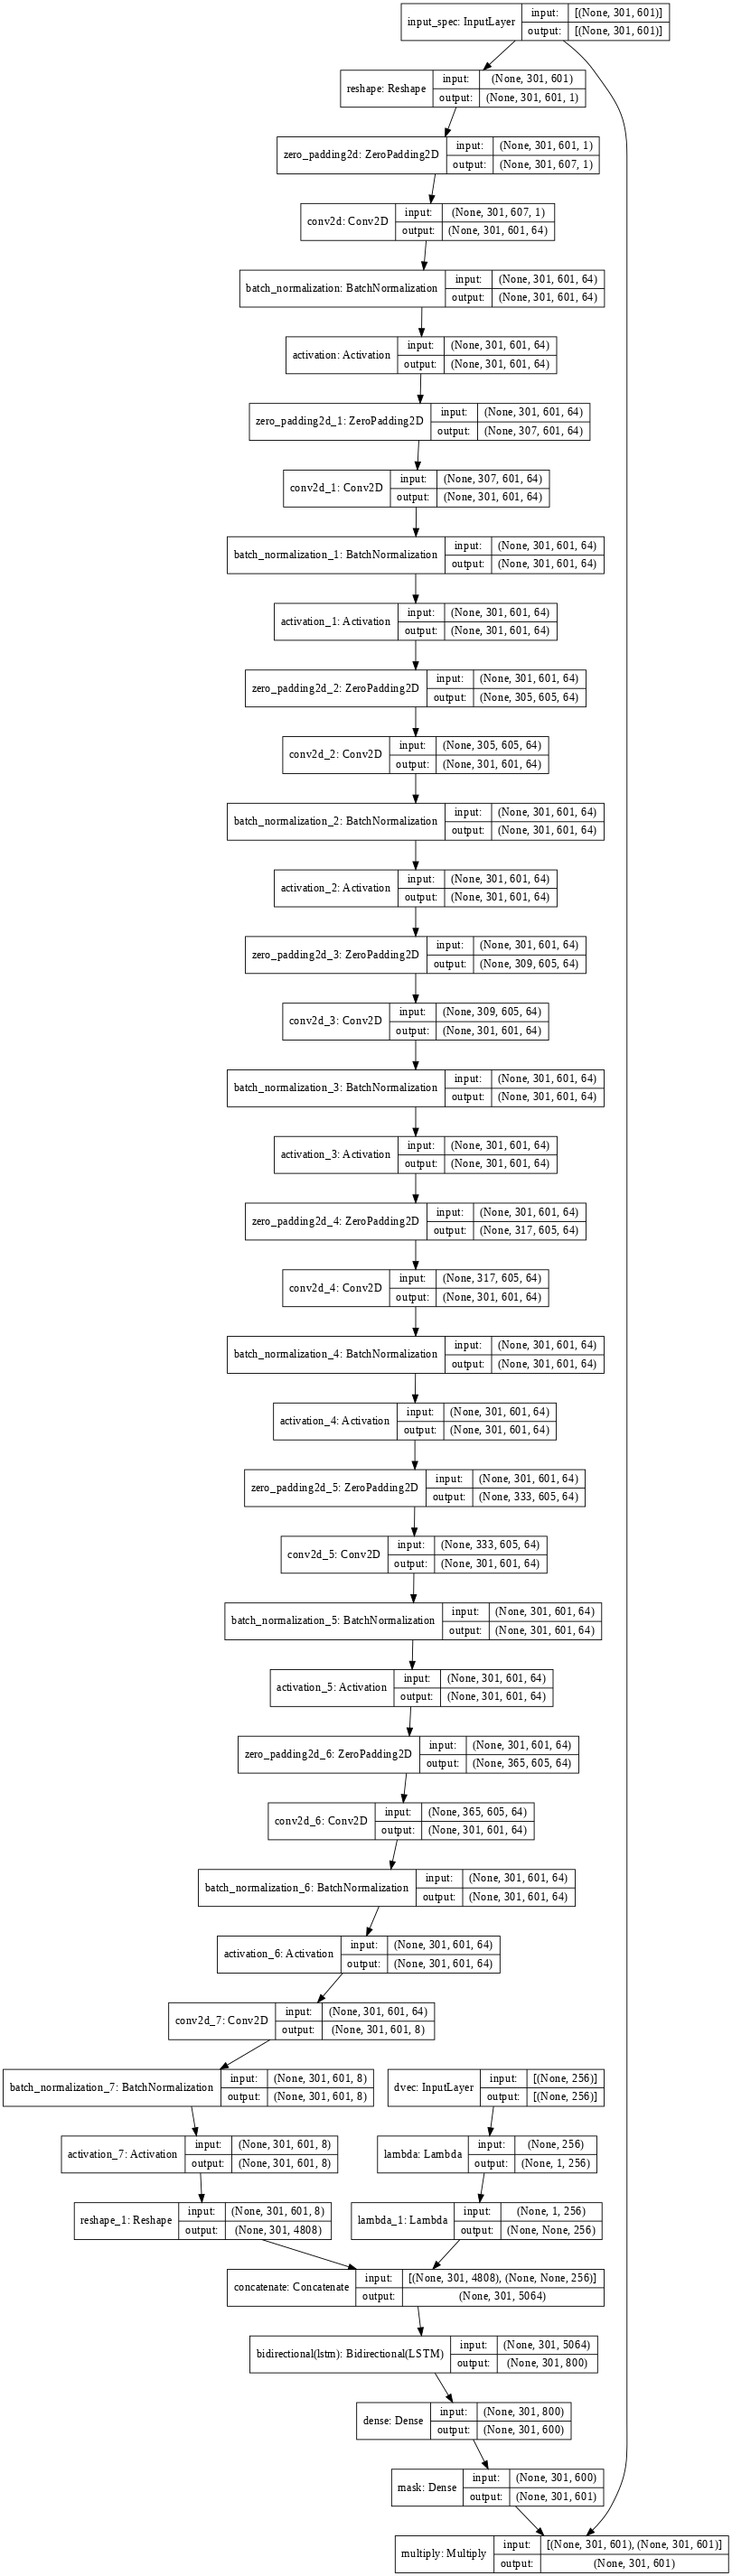

In [ ]:
model.compile(optimizer='adam', loss='mse')
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Load Data and Train


In [ ]:
!pip install mir_eval

     |████████████████████████████████| 92kB 5.8MB/s 
  Created wheel for mir-eval: filename=mir_eval-0.6-cp37-none-any.whl size=96515 sha256=2146c4ebd5d92847fff7ccee95a0d3fa4c6ab67389d4c3e4125d40ea2ce7b267
  Stored in directory: /root/.cache/pip/wheels/49/ce/30/730fa72addf275e49d90683b01b3613048b4be3bf7ff8eb6ec
Successfully built mir-eval


In [ ]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras.utils import Sequence

In [ ]:
# loads the numpy arrays whose path is stored in the column "col" of "data_frame"
def load_col_data(data_frame ,indices, start_pos, end_pos, col):
  col_list = []
  for i in range(start_pos,end_pos):
    idx = indices[i]
    col_list.append(np.load(data_frame[col][idx]))
    # print(idx)
  return np.array(col_list)

In [ ]:
## preload training data into 8 separate folders to avoid issues with gdrive
def preload_training_data(cur_fraction, start_pos, end_pos):
  input_spec = load_col_data(df_train, list(range(num_samples)) , start_pos , end_pos ,'input_spec_path' )
  np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'input_spec'),input_spec)
  output_spec = load_col_data(df_train, list(range(num_samples)), start_pos, end_pos, 'output_spec_path')
  np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'output_spec'), output_spec)
  dvec = load_col_data(df_train, list(range(num_samples)), start_pos, end_pos, 'dvec_path')
  np.save(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(cur_fraction),'dvec'),dvec)

In [ ]:
dataset_train = 'train'
df_train = pd.read_csv(os.path.join(path[dataset_train],'data_frame.csv'))
num_samples = df_train.shape[0]

In [ ]:
## takes approx _ mins
### execute just once ###
# preload training data
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_0/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_1/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_2/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_3/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_4/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_5/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_6/'
!mkdir 'LibriSpeech Dataset/PreLoad Training Dataset/fraction_7/'
for cur_fraction in range(num_fractions):
  start_pos = 0
  for i in range(cur_fraction):
    start_pos+=fraction_sizes[i]
  end_pos = start_pos + fraction_sizes[cur_fraction]
  preload_training_data(cur_fraction, start_pos, end_pos)
  start_pos, end_pos
  print(cur_fraction,'/',num_fractions)

0 / 8
1 / 8
2 / 8
3 / 8
4 / 8
5 / 8
6 / 8
7 / 8


In [ ]:
steps_per_epoch = 0
for i in range(num_fractions):
  steps_per_epoch += (fraction_sizes[i]+batch_size-1)//batch_size
print(steps_per_epoch)

952


In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class data_generator(Sequence):
  def __init__(self, fraction_sizes , batch_size):
    self.batch_size = batch_size
    self.fraction_sizes = fraction_sizes
    self.num_fractions = len(fraction_sizes)
    self.num_samples = sum(self.fraction_sizes)
    self.pos = 0
    self.cur_fraction = 0
    self.input_spec=None
    self.output_spec=None
    self.dvec=None
  def __len__(self):
    self.num_batches = 0
    for i in range(self.num_fractions):
      self.num_batches += (self.fraction_sizes[i]+self.batch_size-1)//self.batch_size
    #print("len ",self.num_batches)
    return self.num_batches
  def __getitem__(self,batch_index):
    if batch_index == 0:
      self.pos = 0
    start_pos = self.pos
    end_pos = start_pos + self.batch_size
    if end_pos > self.fraction_sizes[self.cur_fraction]:
      end_pos = self.fraction_sizes[self.cur_fraction]
    if start_pos == 0 :
      print("Loading new data")
      if self.input_spec is not None:
        print("de-allocating memory space of old data")
        del self.input_spec
        del self.output_spec
        del self.dvec
        print("de-allocation complete")
      indices = np.random.permutation(self.fraction_sizes[self.cur_fraction])
      self.input_spec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'input_spec.npy'))[indices]
      self.output_spec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'output_spec.npy'))[indices]
      self.dvec = np.load(os.path.join(dataset_path,'PreLoad Training Dataset','fraction_'+str(self.cur_fraction),'dvec.npy'))[indices]
      del indices
      print("New data loaded")
    if end_pos == self.fraction_sizes[self.cur_fraction]:
      self.cur_fraction += 1
      if self.cur_fraction == self.num_fractions:
        self.cur_fraction = 0
      self.pos = 0
    else :
      self.pos = end_pos
    input_spec_batch = np.copy(self.input_spec[start_pos:end_pos])  # creating a copy so that input_spec, output_spec, dvec can be deleted when loading subsequent batches
    dvec_batch = np.copy(self.dvec[start_pos:end_pos])
    output_spec_batch = np.copy(self.output_spec[start_pos:end_pos])
    return ({'input_spec':input_spec_batch, 'dvec': dvec_batch}, output_spec_batch)
  def on_epoch_end(self):
    self.pos = 0
    self.cur_fraction = 0

In [ ]:
gen_train = data_generator(fraction_sizes, batch_size)

In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm

In [ ]:
model_checkpoint_callback = ModelCheckpoint(
    os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch{epoch:04d}.h5'),save_weights_only=True)

In [ ]:
### config ###
initial_epoch = 30
epochs = 40
batch_size = 8

In [ ]:
### execute just once ###
# !mkdir "drive/MyDrive/LibriSpeech Dataset/Model weights/"
# model.save_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0000.h5'))

In [ ]:
model.load_weights(os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0030.h5'))

In [ ]:
hist = model.fit(gen_train, epochs=epochs, verbose=1, steps_per_epoch = steps_per_epoch, shuffle=False,
                 initial_epoch = initial_epoch,
          callbacks=[ model_checkpoint_callback ] )
# !cp -r "LibriSpeech Dataset/Model weights/" "drive/MyDrive/LibriSpeech Dataset/"

Loading new data
New data loaded
Epoch 31/40
Loading new data
de-allocating memory space of old data
de-allocation complete
New data loaded
118/952 [==>...........................] - ETA: 10:57 - loss: 0.0063Loading new data
de-allocating memory space of old data
de-allocation complete
237/952 [======>.......................] - ETA: 10:21 - loss: 0.0063Loading new data
de-allocating memory space of old data
de-allocation complete
356/952 [==========>...................] - ETA: 8:53 - loss: 0.0062Loading new data
de-allocating memory space of old data
de-allocation complete
475/952 [=============>................] - ETA: 7:12 - loss: 0.0062Loading new data
de-allocating memory space of old data
de-allocation complete
594/952 [=================>............] - ETA: 5:27 - loss: 0.0062Loading new data
de-allocating memory space of old data
de-allocation complete
713/952 [=====================>........] - ETA: 3:39 - loss: 0.0062Loading new data
de-allocating memory space of old data
de-al

In [ ]:
loss = hist.history['loss']
# !mkdir "drive/MyDrive/LibriSpeech Dataset/Training Loss/"
np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Training Loss/training_loss_total_epochs%04d'%epochs),np.array(loss))

### Visualize model training

In [ ]:
!pip install mir_eval

In [ ]:
import pandas as pd
import numpy as np
from mir_eval.separation import bss_eval_sources
from tqdm import tqdm

In [ ]:
def load_col_data(data_frame ,indices, start_pos, end_pos, col):
  col_list = []
  for i in range(start_pos,end_pos):
    idx = indices[i]
    col_list.append(np.load(data_frame[col][idx]))
    # print(idx)
  return np.array(col_list)

In [ ]:
dataset = 'dev'

In [ ]:
### To be executed just once ###
# preload all data into disk
df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
output_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'output_spec_path')
output_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'output_phase_path')
input_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'input_spec_path')
input_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'input_phase_path')
dvec = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'dvec_path')
np.save(os.path.join(path[dataset],'output_spec.npy'),output_spec)
np.save(os.path.join(path[dataset],'output_phase.npy'),output_phase)
np.save(os.path.join(path[dataset],'input_spec.npy'),input_spec)
np.save(os.path.join(path[dataset],'input_phase.npy'),input_phase)
np.save(os.path.join(path[dataset],'dvec.npy'),dvec)

In [ ]:
# load the dev dataset
input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

In [ ]:
# re construct target waves using output spectrogram and output phase
target_waves = []
for i in tqdm(range(output_spec.shape[0])):
  target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))
val_loss = []
val_sdr = []

100%|██████████| 920/920 [00:19<00:00, 46.06it/s]


In [ ]:
def compute_loss_sdr(weights_path):
  model.load_weights(weights_path)
  predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
  val_loss.append(np.mean(np.square(output_spec - predict_spec)))
  sdr=[]
  for i in tqdm(range(predict_spec.shape[0])):
    predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
    sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
  val_sdr.append(np.median(np.array(sdr)))

In [ ]:
### config ###
start_epochs = 40
end_epochs = 41

In [ ]:
for i in range(start_epochs,end_epochs):
  weights_path = os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch%04d.h5'%i)
  compute_loss_sdr(weights_path)
print()
print(val_loss)
print(val_sdr)
np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/val_loss_total_epochs%04d'%(end_epochs-1)),np.array(val_loss))
np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/val_sdr_total_epochs%04d'%(end_epochs-1)),np.array(val_sdr))

115/115 [==============================] - 29s 240ms/step


100%|██████████| 920/920 [00:59<00:00, 15.38it/s]


[0.011672994]
[4.381160192481018]


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ## copied
# # load the dev dataset
# input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
# input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
# output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
# output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
# dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

# # re construct target waves using output spectrogram and output phase
# target_waves = []
# for i in tqdm(range(output_spec.shape[0])):
#   target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))
# val_loss = []
# val_sdr = []

# def compute_loss_sdr(weights_path):
#   model.load_weights(weights_path)
#   predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
#   val_loss.append(np.mean(np.square(output_spec - predict_spec)))
#   sdr=[]
#   for i in tqdm(range(predict_spec.shape[0])):
#     predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
#     sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
#   val_sdr.append(np.median(np.array(sdr)))

# ### config ###
# start_epochs = 20
# end_epochs = 21

# for i in range(start_epochs,end_epochs):
#   weights_path = os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch%04d.h5'%i)
#   compute_loss_sdr(weights_path)
# print()
# print(val_loss)
# print(val_sdr)
# np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/val_loss_total_epochs%04d'%(end_epochs-1)),np.array(val_loss))
# np.save(os.path.join('drive/MyDrive/LibriSpeech Dataset/Dev Loss/val_sdr_total_epochs%04d'%(end_epochs-1)),np.array(val_sdr))

# import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
loss = np.load(os.path.join('drive/MyDrive/LibriSpeech Dataset/Training Loss/training_loss_total_epochs%04d.npy'%(end_epochs-1)))

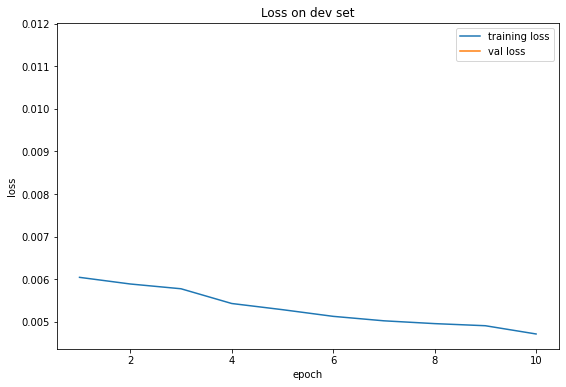

In [ ]:
# plot loss on train and dev set
fig , axis = plt.subplots(1,1,figsize = (9,6))
axis.plot(np.array(range(1,len(loss)+1)),loss,label="training loss")
axis.plot(np.array(range(1,len(val_loss)+1)),val_loss,label="val loss")
axis.legend()
#plt.xticks(np.array(range(len(loss)+1)))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss on dev set')
plt.show()
fig.savefig('loss.png')

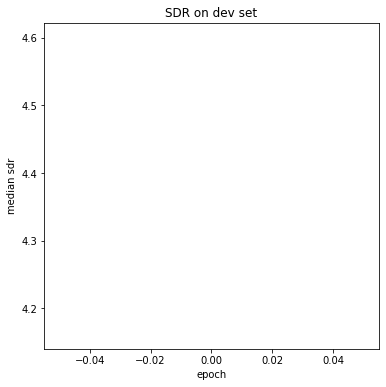

In [ ]:
# plot sdr on dev set
fig , axis = plt.subplots(1,1,figsize = (6,6))
axis.plot(np.array(range(len(val_sdr))), val_sdr, label = "median sdr on val set")
plt.xlabel('epoch')
plt.ylabel('median sdr')
plt.title('SDR on dev set')
plt.show()
fig.savefig('sdr.png')

### Test set metrics

In [ ]:
dataset = 'test'

In [ ]:
### To be executed just once ###
# preload all data into disk
df = pd.read_csv(os.path.join(path[dataset],'data_frame.csv'))
output_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'output_spec_path')
output_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'output_phase_path')
input_spec = load_col_data(df, list(range(df.shape[0])), 0 , df.shape[0] ,'input_spec_path')
input_phase = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'input_phase_path')
dvec = load_col_data(df,list(range(df.shape[0])), 0 , df.shape[0] ,'dvec_path')
np.save(os.path.join(path[dataset],'output_spec.npy'),output_spec)
np.save(os.path.join(path[dataset],'output_phase.npy'),output_phase)
np.save(os.path.join(path[dataset],'input_spec.npy'),input_spec)
np.save(os.path.join(path[dataset],'input_phase.npy'),input_phase)
np.save(os.path.join(path[dataset],'dvec.npy'),dvec)

In [ ]:
# load the entire dataset
input_spec = np.load(os.path.join(path[dataset],'input_spec.npy'))
input_phase = np.load(os.path.join(path[dataset],'input_phase.npy'))
output_spec = np.load(os.path.join(path[dataset],'output_spec.npy'))
output_phase = np.load(os.path.join(path[dataset],'output_phase.npy'))
dvec = np.load(os.path.join(path[dataset],'dvec.npy'))

In [ ]:
# re construct target waves using output spectrogram and output phase
target_waves = []
for i in tqdm(range(output_spec.shape[0])):
  target_waves.append(audio.spec2wave(output_spec[i], output_phase[i]))

100%|██████████| 949/949 [00:13<00:00, 68.12it/s]


In [ ]:
def compute_loss_sdr_test(weights_path):
  model.load_weights(weights_path)
  predict_spec = model.predict(x={'input_spec':input_spec,'dvec':dvec} , batch_size = batch_size, verbose = 1)
  test_loss = np.mean(np.square(output_spec - predict_spec))
  sdr=[]
  for i in tqdm(range(predict_spec.shape[0])):
    predict_wave = audio.spec2wave(predict_spec[i], input_phase[i])
    sdr.append(bss_eval_sources(target_waves[i], predict_wave, False)[0][0])
  test_sdr = np.median(np.array(sdr))
  return test_loss, test_sdr

In [ ]:
weights_path = os.path.join('drive/MyDrive/LibriSpeech Dataset/Model weights','weights_epoch0040.h5')
print("")
print("loss, sdr : ",end="")
print(compute_loss_sdr_test(weights_path))


119/119 [==============================] - 29s 241ms/step


100%|██████████| 949/949 [01:00<00:00, 15.80it/s]


(0.011300437, 4.671808589662419)


### Test audio samples

In [ ]:
## preprocess audio in the same way as training audio input
def preprocess_audio(audio_path):
  wave,_ = librosa.load(audio_path,sr=hyper_params.sample_rate) 
  wave,_ = librosa.effects.trim(wave, top_db=20)  #trim silent portions
  length_wave = int(hyper_params.sample_rate * hyper_params.data_audio_len) 
  if(wave.shape[0]<length_wave) :
    return
  wave = wave[:length_wave] #clip wave to a fixed wavelength
  norm = np.max(np.abs(wave)) * 1.1 #normalize
  wave = wave/norm
  return wave

In [ ]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec_path, phase_path, dvec_path):
  input_spec = np.load(input_spec_path)
  phase = np.load(phase_path)
  dvec = np.load(dvec_path)
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)

In [ ]:
from IPython.display import Audio as ipythonAudio
import pandas as pd
import numpy as np
import librosa
import random

In [ ]:
## pass input spec and dvec thru model and re construct wave after combining with input phase
def get_filtered_wave(input_spec, phase, dvec):
  dvec = np.expand_dims(dvec,axis=0)
  input_spec = np.expand_dims(input_spec,axis=0)
  clean_spec = model.predict(x={ 'input_spec' : input_spec, 'dvec' : dvec}, verbose=1)
  wave = audio.spec2wave(clean_spec[0],phase)
  return np.asarray(wave)

#workflow to test model on random audio speech
hyper_params = HyperParams()
audio = Audio(hyper_params)

# ref_wave = preprocess_audio("drive/MyDrive/LibriSpeech Dataset/Sample Audios/1_ref.wav")
ref_wave,_ = librosa.load("drive/MyDrive/LibriSpeech Dataset/Sample Audios/8_ref.wav", sr=hyper_params.sample_rate)
ref_wave,_ = librosa.effects.trim(ref_wave, top_db = 20)
# print(type(ref_wave))

dvec = get_dvector(ref_wave)
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

In [ ]:
noisy_wave = preprocess_audio("drive/MyDrive/LibriSpeech Dataset/Sample Audios/8_clean.wav")
noisy_spec, noisy_phase = audio.wave2spec(noisy_wave)
ipythonAudio(noisy_wave, rate = hyper_params.sample_rate)

In [ ]:
filtered_wave = get_filtered_wave(noisy_spec, noisy_phase, dvec)
ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

1/1 [==============================] - 0s 498ms/step


In [ ]:
voicefilter_wave = preprocess_audio("drive/MyDrive/LibriSpeech Dataset/Sample Audios/8_out.wav")
noisy_spec, noisy_phase = audio.wave2spec(voicefilter_wave)
ipythonAudio(voicefilter_wave, rate = hyper_params.sample_rate)

In [ ]:
dataset_audio = 'train'
df = pd.read_csv(os.path.join(path[dataset_audio],'data_frame.csv'))
print(df)

        key  ...                                          dvec_path
0     28946  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
1     28947  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
2     28948  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
3     28949  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
4     28950  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
...     ...  ...                                                ...
7588  54680  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
7589  54681  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
7590  54682  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
7591  54683  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...
7592  54684  ...  ./LibriSpeech Dataset/LibriSpeech Train Datase...

[7593 rows x 9 columns]


In [ ]:
idx = random.choice(range(df.shape[0]))
print(idx)

5850


In [ ]:
# ref speech used for d vector
ref_wave,_ = librosa.load(df['ref_speech'][idx],sr=hyper_params.sample_rate)
print(df['ref_speech'][idx])
ipythonAudio(ref_wave, rate = hyper_params.sample_rate)

./LibriSpeech Dataset/LibriSpeech Train Dataset/LibriSpeech/train-clean-100/6476/96661/6476-96661-0022.flac


In [ ]:
# primary speech
pri_wave,_ = librosa.load(df['pri_speech'][idx],sr=hyper_params.sample_rate)
print(df['pri_speech'][idx])
ipythonAudio(pri_wave, rate = hyper_params.sample_rate)

./LibriSpeech Dataset/LibriSpeech Train Dataset/LibriSpeech/train-clean-100/6476/57446/6476-57446-0076.flac


In [ ]:
# secondary speech
sec_wave,_ = librosa.load(df['sec_speech'][idx],sr=hyper_params.sample_rate)
print(df['sec_speech'][idx])
ipythonAudio(sec_wave, rate = hyper_params.sample_rate)

./LibriSpeech Dataset/LibriSpeech Train Dataset/LibriSpeech/train-clean-100/3436/172162/3436-172162-0028.flac


In [ ]:
noisy_spec_path = df['input_spec_path'][idx]
output_spec_path = df['output_spec_path'][idx]
input_phase_path = df['input_phase_path'][idx]
output_phase_path = df['output_phase_path'][idx]
dvec_path = df['dvec_path'][idx]
noisy_spec = np.load(noisy_spec_path)
input_phase = np.load(input_phase_path)

In [ ]:
# mixed audio input
noisy_wave = audio.spec2wave( noisy_spec, input_phase )
ipythonAudio(noisy_wave, rate = hyper_params.sample_rate)

In [ ]:
# filtered audio from model
#filtered_wave = get_filtered_wave( noisy_spec_path, input_phase_path, dvec_path )
#ipythonAudio(filtered_wave, rate = hyper_params.sample_rate)

In [ ]:
# ideal target wave
target_wave = audio.spec2wave( np.load(output_spec_path), np.load(output_phase_path))
ipythonAudio(target_wave, rate = hyper_params.sample_rate)

In [ ]:
import soundfile as sf
# sf.write('stereo_file1.wav', reduced_noise, 48000, 'PCM_24')

sf.write('noise.flac', noisy_wave , sr=hyper_params.sample_rate)
sf.write('clean.flac', filtered_wave , sr=hyper_params.sample_rate)